## Compare the likeilhoods generated by LFIAX, SBI (pyknos, maybe), and LAMPE

Starting with the LFIAX likelihood.

In [15]:
from collections import deque

import jax
import jax.numpy as jnp
import jax.lax as lax
import jax.random as jrandom
import numpy as np
import optax
import distrax
import haiku as hk

import tensorflow as tf
import tensorflow_datasets as tfds

from lfiax.flows.nsf import make_nsf

from typing import (
    Any,
    Iterator,
    Mapping,
    Optional,
    Tuple,
)

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


def sim_linear_jax(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)

    n_n = distrax.Independent(
        distrax.MultivariateNormalDiag(mu_noise, sigma_noise)
    ).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(priors[:, 1], 0)
    y = y + jnp.squeeze(n_n)
    ygrads = priors[:, 1]

    return y, ygrads


def sim_linear_jax_laplace(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    concentration = jnp.ones(noise_shape)
    rate = jnp.ones(noise_shape)

    n_n = distrax.Gamma(concentration, rate).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = distrax.MultivariateNormalDiag(y, jnp.squeeze(n_n)).sample(seed=keys[1], sample_shape=())

    return y


def sim_data_laplace(d: Array, priors: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)
    theta_shape = (1,)

    loc = jnp.zeros(theta_shape)
    scale = jnp.ones(theta_shape)

    # Leaving in case this fixes future dimensionality issues
    # base_distribution = distrax.Independent(
    #     distrax.Laplace(loc, scale)
    # )
    base_distribution = distrax.Laplace(loc, scale)

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    y = sim_linear_jax_laplace(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )


# ----------------------------------------
# Helper functions to simulate data
# ----------------------------------------
def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = split
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=1000)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


def sim_data(d: Array, priors: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)

    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    # sigma = (3**2) * jnp.ones(theta_shape)
    sigma = jnp.ones(theta_shape)

    base_distribution = distrax.Independent(  # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma)
    )

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    # ygrads allows to be compared to other implementations (Kleinegesse et)
    y, ygrads = sim_linear_jax(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:
    # Batch is [y, thetas, d]
    data = batch.astype(np.float32)
    # Handling the scalar case
    if data.shape[1] <= 3:
        x = jnp.expand_dims(data[:, :-2], -1)
    x = data[:, :len_x]
    cond_data = data[:, len_x:]
    theta = cond_data[:, :-len_x]
    d = cond_data[:, -len_x:-len_xi]
    xi = cond_data[:, -len_xi:]
    return x, theta, d, xi


# ----------------------------
# Haiku transform functions for training and evaluation
# ----------------------------
@hk.without_apply_rng
@hk.transform
def log_prob(data: Array, theta: Array, d: Array, xi: Array) -> Array:
    # Get batch
    shift = data.mean(axis=0)
    scale = data.std(axis=0) + 1e-14

    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
        standardize_x=True,
        standardize_theta=False,
        use_resnet=True,
        event_dim=EVENT_DIM,
        shift=shift,
        scale=scale,
    )
    return model.log_prob(data, theta, d, xi)


@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int, cond_data: Array) -> Array:
    # TODO: update this method?
    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
    )
    z = jnp.repeat(cond_data, num_samples, axis=0)
    z = jnp.expand_dims(z, -1)
    return model._sample_n(key=key, n=[num_samples], z=z)


def loss_fn(
    params: hk.Params, prng_key: PRNGKey, x: Array, theta: Array, d: Array, xi: Array
) -> Array:
    # Loss is average negative log likelihood.
    loss = -jnp.mean(log_prob.apply(params, x, theta, d, xi))
    return loss


@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
    x, theta, d, xi = prepare_data(batch)
    loss = -jnp.mean(log_prob.apply(params, x, theta, d, xi))
    return loss


@jax.jit
def update(
    params: hk.Params, prng_key: PRNGKey, opt_state: OptState, batch: Batch
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    # x, cond_data = prepare_data(batch, prng_key)
    x, theta, d, xi = prepare_data(batch)
    grads = jax.grad(loss_fn)(params, prng_key, x, theta, d, xi)
    grads_d = jax.grad(loss_fn, argnums=5)(params, prng_key, x, theta, d, xi)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, grads_d

# Define the monitor function for early stopping
def monitor_fun(params, i, g):
    # if i < warmup_steps:
    #     learning_rate = initial_learning_rate * i / warmup_steps
    # else:
    #     learning_rate = final_learning_rate
    return jnp.mean(g ** 2), learning_rate


# TODO: Put this in hydra config file
seed = 1231
key = jrandom.PRNGKey(seed)

# d = jnp.array([-10.0, 0.0, 5.0, 10.0])
# d = jnp.array([1., 2.])
# d = jnp.array([1.])
# d_obs = jnp.array([0.])
d_obs = jnp.array([])
# d_prop = jrandom.uniform(key, shape=(1,), minval=-10.0, maxval=10.0)
d_prop = jnp.array([0.])
# d_prop = jnp.array([])
d_sim = jnp.concatenate((d_obs, d_prop), axis=0)
len_x = len(d_sim)
len_d = len(d_obs)
len_xi = len(d_prop)
num_samples = 100

# Params and hyperparams
theta_shape = (1,)
d_shape = (len(d_obs),)
xi_shape = (len_xi,)
EVENT_SHAPE = (len(d_sim),)
# EVENT_DIM is important for the normalizing flow's block.
EVENT_DIM = 1
cond_info_shape = (theta_shape[0], len_d, len_xi)

batch_size = 128
flow_num_layers = 5 #3 # 10
mlp_num_layers = 4 # 3 # 4
hidden_size = 128 # 500
num_bins = 4
learning_rate = 1e-4
warmup_steps = 100
early_stopping_memory = 10
early_stopping_threshold = 5e-2

training_steps = 500
eval_frequency = 10

optimizer = optax.adam(learning_rate)

# Simulating the data to be used to train the flow.
num_samples = 10000
# TODO: put this function in training since d will be changing.
X = sim_data_laplace(d_sim, num_samples, key)

# Create tf dataset from sklearn dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# Splitting into train/validate ds
train = dataset.skip(2000)
val = dataset.take(2000)

# load_dataset(split: tfds.Split, batch_size: int)
train_ds = load_dataset(train, 512)
valid_ds = load_dataset(val, 512)

# Training
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(
    next(prng_seq),
    np.zeros((1, *EVENT_SHAPE)),
    np.zeros((1, *theta_shape)),
    np.zeros((1, *d_shape)),
    np.zeros((1, *xi_shape)),
)
opt_state = optimizer.init(params)

# Can change the length of the deque for more/less leniency in measuring the loss
loss_deque = deque(maxlen=early_stopping_memory)
for step in range(training_steps):
    params, opt_state, grads_d = update(
        params, next(prng_seq), opt_state, next(train_ds)
    )

    if step % eval_frequency == 0:
        val_loss = eval_fn(params, next(valid_ds))
        print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")
    
        loss_deque.append(val_loss)
        avg_abs_diff = jnp.mean(abs(jnp.array(loss_deque) - sum(loss_deque)/len(loss_deque)))
        if step > warmup_steps and avg_abs_diff < early_stopping_threshold:
            break


STEP:     0; Validation loss: 2.168
STEP:    10; Validation loss: 2.132
STEP:    20; Validation loss: 2.122
STEP:    30; Validation loss: 2.097
STEP:    40; Validation loss: 2.098
STEP:    50; Validation loss: 2.181
STEP:    60; Validation loss: 2.126
STEP:    70; Validation loss: 2.115
STEP:    80; Validation loss: 2.096
STEP:    90; Validation loss: 2.192
STEP:   100; Validation loss: 2.105
STEP:   110; Validation loss: 2.122


In [2]:
X.shape

(10000, 3)

In [20]:
x = X[:, :1]
y = X[:, 1:3]

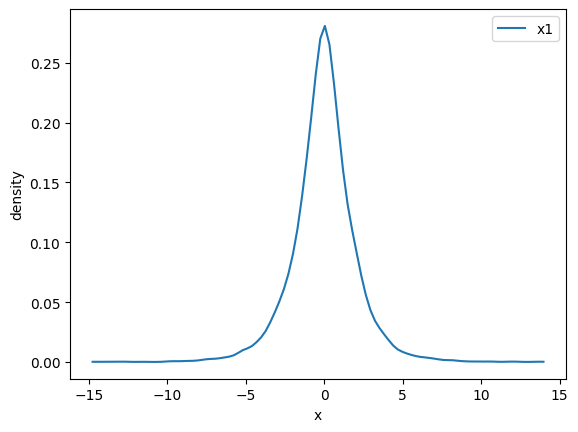

In [21]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Compute the density
density_1 = gaussian_kde(x[:, 0])
# density_2 = gaussian_kde(x[:, 1])

# Plot the density
fig, ax = plt.subplots()
x = np.linspace(jnp.min(x), jnp.max(x), 100)
ax.plot(x, density_1(x), label='x1')
# ax.plot(x, density_2(x), label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()


## Testing LFIAX sampling
Now testing the conditional normalizing flow's sampling.

In [26]:
theta_test = jnp.expand_dims(X[:, 1], -1)
# d_test = jnp.expand_dims(X[:, 4], -1)
# xi_test = jnp.expand_dims(X[:, 2], -1)
# xi_test = jnp.ones((10000, 1)) * 3
xi_test = jnp.expand_dims(X[:, 1], -1)

In [22]:
@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int, theta: Array, d: Array, xi: Array) -> Array:
# def model_sample(key: PRNGKey, num_samples: int, cond_data: Array) -> Array:
    # TODO: Change cond_data to be the array that the flow expects
    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
        standardize_x=False,
        standardize_theta=False,
        use_resnet=True,
        event_dim=EVENT_DIM,
        # shift=shift,
        # scale=scale,
    )
    # This works for class-conditional data. Not necessary anymore.
    # z = jnp.repeat(cond_data, num_samples, axis=0)
    # z = jnp.expand_dims(z, -1)
    return model._sample_n(key=key, n=[num_samples], theta=theta, d=d, xi=xi)

# model_sample(key, 10, theta_test, d_test, xi_test)

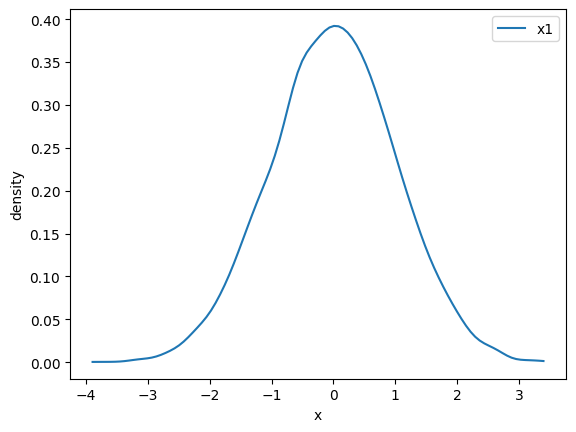

In [27]:
samples = model_sample.apply(params, 
                    next(prng_seq),
                    num_samples=len(theta_test),
                    theta=theta_test,
                    # d=d_test,
                    d=d_obs,
                    xi=xi_test)

density_1 = gaussian_kde(samples[:, 0])
# density_2 = gaussian_kde(samples[:, 1])

# Plot the density
fig, ax = plt.subplots()
x = np.linspace(jnp.min(samples), jnp.max(samples), 100)
ax.plot(x, density_1(x), label='x1')
# ax.plot(x, density_2(x), label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()

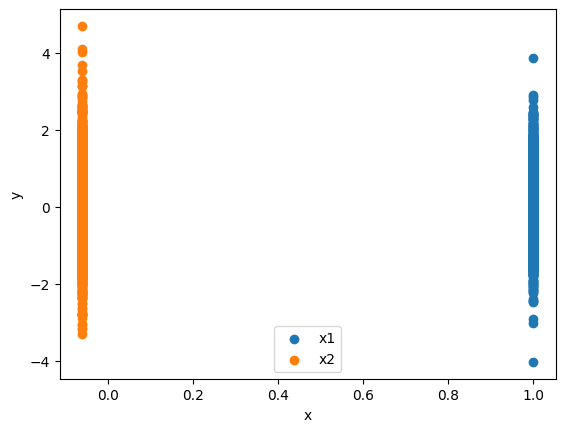

In [21]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

fig, ax = plt.subplots()
ax.scatter(jnp.ones(samples.shape[0])*d_sim[0], samples[:, 0], label='x1')
ax.scatter(jnp.ones(samples.shape[0])*d_sim[1], samples[:, 1], label='x2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


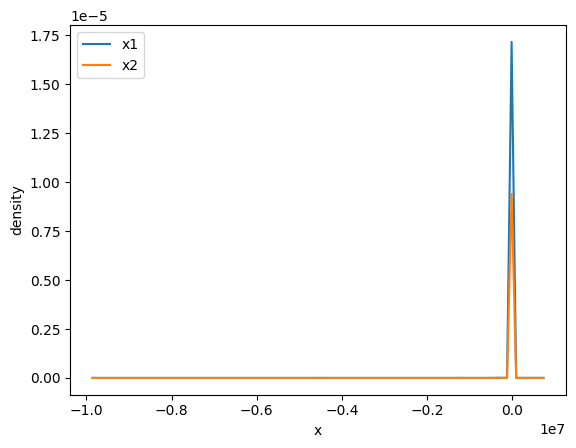

In [70]:
from scipy.stats import gaussian_kde

# Compute the density
density_1 = gaussian_kde(samples[:, 0])
density_2 = gaussian_kde(samples[:, 1])

# Plot the density
fig, ax = plt.subplots()
x = np.linspace(jnp.min(samples), jnp.max(samples), 100)
ax.plot(x, density_1(x), label='x1')
ax.plot(x, density_2(x), label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()


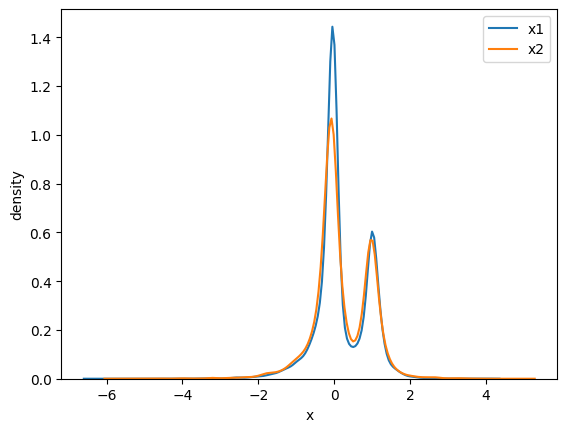

In [8]:
import seaborn as sns
sns.kdeplot(samples[:, 0], label='x1')
sns.kdeplot(samples[:, 1], label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()


## Compare to `pyro` regression model w/ explicit likelihood

In [11]:
import torch
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro import poutine
from pyro.contrib.util import rmv, lexpand
import numbers

# As a reminder, here's the parameters I used for this linear regression
def sim_linear_jax_laplace(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    concentration = jnp.ones(noise_shape)
    rate = jnp.ones(noise_shape)

    n_n = distrax.Gamma(concentration, rate).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = distrax.MultivariateNormalDiag(y, jnp.squeeze(n_n)).sample(seed=keys[1], sample_shape=())
    # y = y + jnp.squeeze(n_n)
    # ygrads = priors[:, 1]

    return y #, ygrads


def sim_data_laplace(d: Array, priors: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)
    theta_shape = (1,)

    loc = jnp.zeros(theta_shape)
    scale = jnp.ones(theta_shape)

    # base_distribution = distrax.Independent(  # Should this be independent?
    #     distrax.Laplace(loc, scale)
    # )
    base_distribution = distrax.Laplace(loc, scale)

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    # ygrads allows to be compared to other implementations (Kleinegesse et)
    y = sim_linear_jax_laplace(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )

d_sim2 = jnp.linspace(-100, 100, num=15)

X_laplace = sim_data_laplace(d_sim2, num_samples, key)
X_laplace.shape

(10000, 31)

In [12]:
x_laplace = X_laplace[:,:15]
x_laplace.shape

(10000, 15)

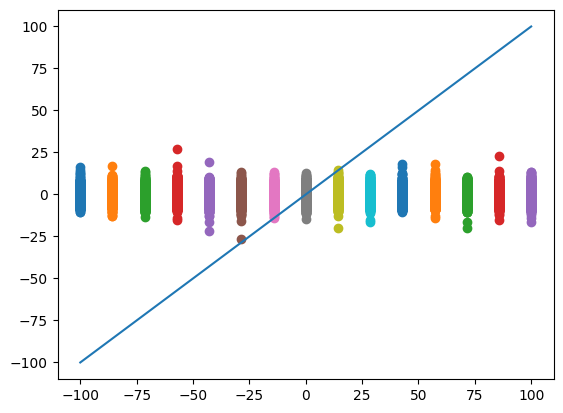

In [13]:
import matplotlib.pyplot as plt

y = 1. * d_sim2
# Plotting
fig, ax = plt.subplots()

ax.plot(d_sim2, y)
for i in range(len(x_laplace[0])):
  ax.scatter([d_sim2[i]] * 10000, x_laplace[:,i])

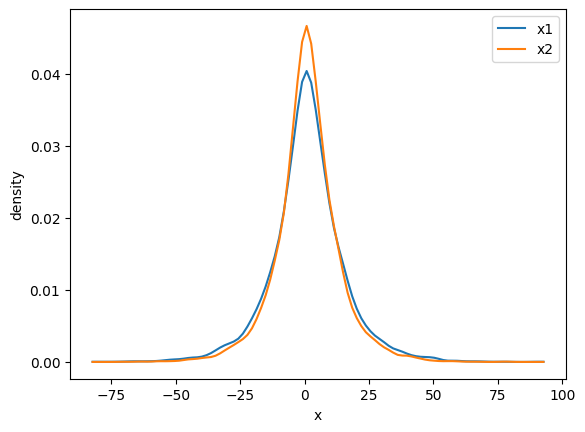

In [107]:
x_laplace = X_laplace[:, :2]
# Compute the density
density_1 = gaussian_kde(x_laplace[:, 0])
density_2 = gaussian_kde(x_laplace[:, 1])

# Plot the density
fig, ax = plt.subplots()
x = np.linspace(jnp.min(x_laplace), jnp.max(x_laplace), 100)
ax.plot(x, density_1(x), label='x1')
ax.plot(x, density_2(x), label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()


In [6]:
import numpy as np

np_d_sim = np.asarray(d_sim2)
torch_d_sim = torch.from_numpy(np_d_sim).cpu()

device = 'cpu'
scale = 1.
p = 1

w_prior_loc = scale * torch.zeros(p, device=device)
w_prior_scale = scale * torch.ones(p, device=device)
sigma_prior_scale = torch.tensor(1., device=device)


/var/folders/j7/tj9yr2g9655ccsm2fwyzbxv40000gn/T/ipykernel_57186/3076341835.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:205.)
  torch_d_sim = torch.from_numpy(np_d_sim).cpu()


In [7]:
torch_d_sim_expanded = lexpand(torch_d_sim, 10000).unsqueeze(1).unsqueeze(-1)
# torch_d_sim_expanded = lexpand(lexpand(torch_d_sim_expanded, 1), 1)
# design shape needs to be [10, 1, 2, 1]... 
torch_d_sim_expanded.shape

torch.Size([10000, 1, 15, 1])

In [8]:
# design = torch_d_sim_expanded

In [9]:
observation_labels = "y"
target_labels = ["w", "sigma"]
# M = 2

def make_regression_model(w_loc, w_scale, sigma_scale, xi_init, observation_label="y"):
    def regression_model(design_prototype):
        design = pyro.param("xi", xi_init)
        print(design)
        # design = (design / design.norm(dim=-1, p=1, keepdim=True)).expand(design_prototype.shape)
        if is_bad(design):
            raise ArithmeticError("bad design, contains nan or inf")
        batch_shape = design.shape[:-2]
        with pyro.plate_stack("plate_stack", batch_shape):
            # `w` is shape p, the prior on each component is independent
            w = pyro.sample("w", dist.Laplace(w_loc, w_scale).to_event(1))
            print(w.shape)
            # `sigma` is scalar
            sigma = 1e-6 + pyro.sample("sigma", dist.Exponential(sigma_scale)).unsqueeze(-1)
            # print(design)
            mean = rmv(design, w)
            sd = sigma
            y = pyro.sample(observation_label, dist.Normal(mean, sd).to_event(1))
            return y

    return regression_model

def torch_isnan(x):
    """
    A convenient function to check if a Tensor contains any nan; also works with numbers
    """
    if isinstance(x, numbers.Number):
        return x != x
    return torch.isnan(x).any()

def torch_isinf(x):
    """
    A convenient function to check if a Tensor contains any +inf; also works with numbers
    """
    if isinstance(x, numbers.Number):
        return x == float('inf') or x == -float('inf')
    return (x == float('inf')).any() or (x == -float('inf')).any()

def is_bad(a):
    return torch_isnan(a) or torch_isinf(a)

model = make_regression_model(
        w_prior_loc, w_prior_scale, sigma_prior_scale, torch_d_sim_expanded)

with poutine.trace():
    trace = poutine.trace(model).get_trace(torch_d_sim_expanded)
    # y_dict_exp = {l: lexpand(trace.nodes[l]["value"], M) for l in observation_labels}
    y_dict = {l: trace.nodes[l]["value"] for l in observation_labels}
    theta_dict = {l: trace.nodes[l]["value"] for l in target_labels}

tensor([[[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]],


        [[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]],


        [[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]],


        ...,


        [[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]],


        [[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]],


        [[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]]], requires_grad=True)
torch.Size([10000, 1, 1])


In [10]:
y_dict['y'].squeeze().shape

torch.Size([10000, 15])

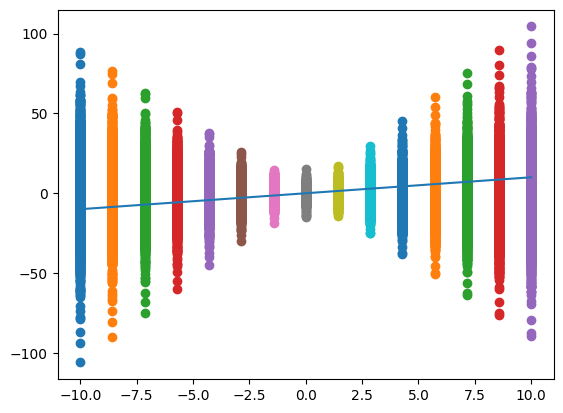

In [14]:
y = 1. * d_sim2
# Plotting
fig, ax = plt.subplots()

ax.plot(d_sim2, y)
for i in range(len(x_laplace[0])):
  ax.scatter([d_sim2[i]] * 10000, y_dict['y'].squeeze().detach().numpy()[:,i])

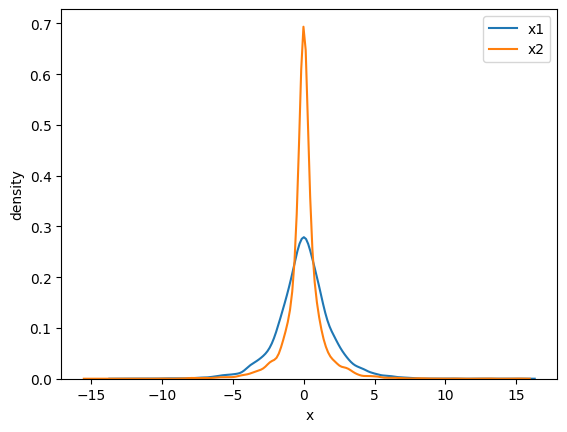

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(y_dict['y'].squeeze().detach().numpy()[:, 0], label='x1')
sns.kdeplot(y_dict['y'].squeeze().detach().numpy()[:, 1], label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()
